### Data Sources
#### https://github.com/nytimes/covid-19-data/blob/master/us-counties.csv - all date cases
#### https://github.com/nytimes/covid-19-data/blob/master/live/us-counties.csv
#### https://coronavirus-resources.esri.com/datasets/1044bb19da8d4dbfb6a96eb1b4ebf629_0/data?page=14
#### https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

### https://healthdata.gov/dataset/covid-19-reported-patient-impact-and-hospital-capacity-facility
###https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
import math
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import utils

In [3]:
today=pd.read_csv('/content/drive/MyDrive/Colab data files/fin_data/us-counties_on_apr4.csv')
cases=pd.read_csv('/content/drive/MyDrive/Colab data files/fin_data/us-counties_till_apr_4.csv')
cases=cases.append(today, ignore_index=True)

Data Preprocessing

In [38]:
cases.shape
cases.dtypes

date                datetime64[ns]
county                      object
state                       object
fips                        object
cases                        int64
deaths                     float64
confirmed_cases            float64
confirmed_deaths           float64
probable_cases             float64
probable_deaths            float64
dtype: object

In [6]:
cases['fips'] = cases['fips'].astype(str)
cases.dtypes

date                 object
county               object
state                object
fips                 object
cases                 int64
deaths              float64
confirmed_cases     float64
confirmed_deaths    float64
probable_cases      float64
probable_deaths     float64
dtype: object

In [7]:
cases = cases[cases['fips'].notna()]
cases['date'] = pd.to_datetime(cases['date'])

In [8]:
cases.head()

,date,county,state,fips,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0,NaN,NaN,NaN,NaN
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0,NaN,NaN,NaN,NaN
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0,NaN,NaN,NaN,NaN
3,2020-01-24,Cook,Illinois,17031.0,1,0.0,NaN,NaN,NaN,NaN
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0,NaN,NaN,NaN,NaN


In [9]:
cases['date'] = pd.to_datetime(cases['date']) - pd.to_timedelta(7, unit='d')
weekly_cases = cases.groupby(['county','state','fips', pd.Grouper(key='date', freq='W')])['cases','deaths','confirmed_cases','confirmed_deaths','probable_cases','probable_deaths'].sum().reset_index().sort_values('date')
weekly_cases.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,county,state,fips,date,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths
96353,Maricopa,Arizona,4013.0,2020-01-19,1,0.0,0.0,0.0,0.0,0.0
34366,Cook,Illinois,17031.0,2020-01-19,3,0.0,0.0,0.0,0.0,0.0
141878,Snohomish,Washington,53061.0,2020-01-19,6,0.0,0.0,0.0,0.0,0.0
115556,Orange,California,6059.0,2020-01-19,2,0.0,0.0,0.0,0.0,0.0
92432,Los Angeles,California,6037.0,2020-01-19,1,0.0,0.0,0.0,0.0,0.0


In [10]:
weekly_cases.shape
weekly_cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171496 entries, 96353 to 171495
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   county            171496 non-null  object        
 1   state             171496 non-null  object        
 2   fips              171496 non-null  object        
 3   date              171496 non-null  datetime64[ns]
 4   cases             171496 non-null  int64         
 5   deaths            171496 non-null  float64       
 6   confirmed_cases   171496 non-null  float64       
 7   confirmed_deaths  171496 non-null  float64       
 8   probable_cases    171496 non-null  float64       
 9   probable_deaths   171496 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 14.4+ MB


In [12]:
hosp_data=pd.read_csv('/content/drive/MyDrive/Colab data files/data/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_Facility 04042021.csv')
hosp_data.head(5)

,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,is_metro_micro,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg,inpatient_beds_7_day_avg,total_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_avg,icu_beds_used_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg,staffed_icu_adult_patients_confirmed_covid_7_day_avg,total_patients_hospitalized_confirmed_influenza_7_day_avg,icu_patients_confirmed_influenza_7_day_avg,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_avg,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,...,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_covid_7_day_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_pediatric_patients_hospitalized_confirmed_covid_7_day_coverage,inpatient_beds_7_day_coverage,total_icu_beds_7_day_coverage,total_staffed_adult_icu_beds_7_day_coverage,icu_beds_used_7_day_coverage,staffed_adult_icu_bed_occupancy_7_day_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage,staffed_icu_adult_patients_confirmed_covid_7_day_coverage,total_patients_hospitalized_confirmed_influenza_7_day_coverage,icu_patients_confirmed_influenza_7_day_coverage,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_coverage,previous_day_admission_adult_covid_confirmed_7_day_sum,previous_day_admission_adult_covid_confirmed_18-19_7_day_sum,previous_day_admission_adult_covid_confirmed_20-29_7_day_sum,previous_day_admission_adult_covid_confirmed_30-39_7_day_sum,previous_day_admission_adult_covid_confirmed_40-49_7_day_sum,previous_day_admission_adult_covid_confirmed_50-59_7_day_sum,previous_day_admission_adult_covid_confirmed_60-69_7_day_sum,previous_day_admission_adult_covid_confirmed_70-79_7_day_sum,previous_day_admission_adult_covid_confirmed_80+_7_day_sum,previous_day_admission_adult_covid_confirmed_unknown_7_day_sum,previous_day_admission_pediatric_covid_confirmed_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_adult_covid_suspected_7_day_sum,previous_day_admission_adult_covid_suspected_18-19_7_day_sum,previous_day_admission_adult_covid_suspected_20-29_7_day_sum,previous_day_admission_adult_covid_suspected_30-39_7_day_sum,previous_day_admission_adult_covid_suspected_40-49_7_day_sum,previous_day_admission_adult_covid_suspected_50-59_7_day_sum,previous_day_admission_adult_covid_suspected_60-69_7_day_sum,previous_day_admission_adult_covid_suspected_70-79_7_day_sum,previous_day_admission_adult_covid_suspected_80+_7_day_sum,previous_day_admission_adult_covid_suspected_unknown_7_day_sum,previous_day_admission_pediatric_covid_suspected_7_day_sum,previous_day_total_ED_visits_7_day_sum,previous_day_admission_influenza_confirmed_7_day_sum,geocoded_hospital_address
0,aab2bb3ab769da90baf57242c96ec481afb5ec6a233784...,2021/04/02,LA,NaN,Crescent City Surgical Centre,NaN,NaN,70118.0,Short Term,NaN,False,10.0,10.0,10.0,-999999.0,-999999.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [13]:
hosp_data['fips_code'] = hosp_data['fips_code'].astype(str)
hosp_data['fips_code'].dtypes

dtype('O')

In [14]:
column_list=['previous_day_admission_adult_covid_confirmed_7_day_sum', 'previous_day_admission_adult_covid_confirmed_18-19_7_day_sum', 'previous_day_admission_adult_covid_confirmed_20-29_7_day_sum','previous_day_admission_adult_covid_confirmed_30-39_7_day_sum','previous_day_admission_adult_covid_confirmed_40-49_7_day_sum', 'previous_day_admission_adult_covid_confirmed_50-59_7_day_sum', 'previous_day_admission_adult_covid_confirmed_60-69_7_day_sum', 'previous_day_admission_adult_covid_confirmed_70-79_7_day_sum', 'previous_day_admission_adult_covid_confirmed_80+_7_day_sum', 'previous_day_admission_adult_covid_confirmed_unknown_7_day_sum', 'previous_day_admission_pediatric_covid_confirmed_7_day_sum']
hosp_data.loc[:,'Previous_cases_total'] = hosp_data[column_list].sum(numeric_only=True, axis=1)

In [15]:
custom_hosp=hosp_data[['fips_code','city','zip','total_beds_7_day_avg',	'all_adult_hospital_beds_7_day_avg', 'total_icu_beds_7_day_avg','total_staffed_adult_icu_beds_7_day_avg',	'icu_beds_used_7_day_avg'	,'staffed_adult_icu_bed_occupancy_7_day_avg', 'inpatient_beds_7_day_coverage','total_icu_beds_7_day_coverage',
                       'icu_beds_used_7_day_coverage','Previous_cases_total']]

In [16]:
custom_hosp.shape
custom_hosp.Previous_cases_total=custom_hosp.Previous_cases_total.mask(custom_hosp.Previous_cases_total.lt(0),0)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [17]:
covid_merge=pd.merge(weekly_cases,custom_hosp,left_on='fips',right_on='fips_code')
covid_merge.head(10)

,county,state,fips,date,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths,fips_code,city,zip,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,total_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_avg,icu_beds_used_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,inpatient_beds_7_day_coverage,total_icu_beds_7_day_coverage,icu_beds_used_7_day_coverage,Previous_cases_total
0,Maricopa,Arizona,4013.0,2020-01-19,1,0.0,0.0,0.0,0.0,0.0,4013.0,PHOENIX,85013.0,48.0,48.0,0.0,0.0,0.0,0.0,2,2,2,0.0
1,Maricopa,Arizona,4013.0,2020-01-19,1,0.0,0.0,0.0,0.0,0.0,4013.0,PHOENIX,85015.0,123.0,123.0,27.0,27.0,19.0,19.0,2,2,2,0.0
2,Maricopa,Arizona,4013.0,2020-01-19,1,0.0,0.0,0.0,0.0,0.0,4013.0,PHOENIX,85016.0,375.0,0.0,120.0,0.0,83.0,0.0,2,2,2,0.0
3,Maricopa,Arizona,4013.0,2020-01-19,1,0.0,0.0,0.0,0.0,0.0,4013.0,SUN CITY,85351.0,464.0,464.0,45.0,45.0,22.0,22.0,2,2,2,0.0
4,Maricopa,Arizona,4013.0,2020-01-19,1,0.0,0.0,0.0,0.0,0.0,4013.0,PHOENIX,85054.0,348.0,348.0,30.0,30.0,23.0,23.0,2,2,2,0.0
5,Maricopa,Arizona,4013.0,2020-01-19,1,0.0,0.0,0.0,0.0,0.0,4013.0,PHOENIX,85032.0,55.5,55.5,14.0,14.0,5.5,5.5,2,2,2,0.0
6,Maricopa,Arizona,4013.0,2020-01-19,1,0.0,0.0,0.0,0.0,0.0,4013.0,PHOENIX,85006.0,94.0,94.0,10.0,10.0,6.5,6.5,2,2,2,0.0
7,Maricopa,Arizona,4013.0,2020-01-19,1,0.0,0.0,0.0,0.0,0.0,4013.0,MESA,85206.0,448.0,448.0,52.0,52.0,22.0,22.0,2,2,2,0.0
8,Maricopa,Arizona,4013.0,2020-01-19,1,0.0,0.0,0.0,0.0,0.0,4013.0,PHOENIX,85027.0,320.0,320.0,40.0,40.0,24.0,24.0,1,1,1,0.0
9,Maricopa,Arizona,4013.0,2020-01-19,1,0.0,0.0,0.0,0.0,0.0,4013.0,PHOENIX,85015.0,45.0,45.0,0.0,0.0,0.0,0.0,2,2,2,0.0


In [18]:
covid_merge.dtypes

county                                               object
state                                                object
fips                                                 object
date                                         datetime64[ns]
cases                                                 int64
deaths                                              float64
confirmed_cases                                     float64
confirmed_deaths                                    float64
probable_cases                                      float64
probable_deaths                                     float64
fips_code                                            object
city                                                 object
zip                                                 float64
total_beds_7_day_avg                                float64
all_adult_hospital_beds_7_day_avg                   float64
total_icu_beds_7_day_avg                            float64
total_staffed_adult_icu_beds_7_day_avg  

In [19]:
covid_merge['fips']=covid_merge['fips'].astype(str)
covid_merge['fips'].dtypes


dtype('O')

In [20]:
covid_merge['total_beds_7_day_avg']=pd.to_numeric(covid_merge['total_beds_7_day_avg'])

In [21]:
#covid_merge=covid_merge.drop(['fips_code'],axis=1)

In [22]:
covid_merge['zip']=covid_merge['zip'].astype(str)
covid_merge['zip'].dtypes

dtype('O')

In [23]:
covid_merge=covid_merge.groupby(['county','state','fips','zip','date']).sum()
covid_merge.reset_index(inplace=True)
covid_merge.head()

,county,state,fips,zip,date,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,total_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_avg,icu_beds_used_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,inpatient_beds_7_day_coverage,total_icu_beds_7_day_coverage,icu_beds_used_7_day_coverage,Previous_cases_total
0,Abbeville,South Carolina,45001.0,29620.0,2020-03-15,144,0.0,0.0,0.0,0.0,0.0,648.0,648.0,-6999982.7,-3999985.7,-6999993.0,-6999993.0,245,236,245,28.0
1,Abbeville,South Carolina,45001.0,29620.0,2020-03-22,756,0.0,0.0,0.0,0.0,0.0,648.0,648.0,-6999982.7,-3999985.7,-6999993.0,-6999993.0,245,236,245,28.0
2,Abbeville,South Carolina,45001.0,29620.0,2020-03-29,1260,0.0,0.0,0.0,0.0,0.0,648.0,648.0,-6999982.7,-3999985.7,-6999993.0,-6999993.0,245,236,245,28.0
3,Abbeville,South Carolina,45001.0,29620.0,2020-04-05,1764,0.0,0.0,0.0,0.0,0.0,648.0,648.0,-6999982.7,-3999985.7,-6999993.0,-6999993.0,245,236,245,28.0
4,Abbeville,South Carolina,45001.0,29620.0,2020-04-12,2880,0.0,0.0,0.0,0.0,0.0,648.0,648.0,-6999982.7,-3999985.7,-6999993.0,-6999993.0,245,236,245,28.0


In [24]:
covid_merge['Possible_difference'] = (covid_merge['Previous_cases_total'] - covid_merge['total_beds_7_day_avg']).abs()
covid_merge['Possible_difference'] = covid_merge['Possible_difference'].astype(int)

In [25]:
covid_merge.head()

,county,state,fips,zip,date,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,total_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_avg,icu_beds_used_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,inpatient_beds_7_day_coverage,total_icu_beds_7_day_coverage,icu_beds_used_7_day_coverage,Previous_cases_total,Possible_difference
0,Abbeville,South Carolina,45001.0,29620.0,2020-03-15,144,0.0,0.0,0.0,0.0,0.0,648.0,648.0,-6999982.7,-3999985.7,-6999993.0,-6999993.0,245,236,245,28.0,620
1,Abbeville,South Carolina,45001.0,29620.0,2020-03-22,756,0.0,0.0,0.0,0.0,0.0,648.0,648.0,-6999982.7,-3999985.7,-6999993.0,-6999993.0,245,236,245,28.0,620
2,Abbeville,South Carolina,45001.0,29620.0,2020-03-29,1260,0.0,0.0,0.0,0.0,0.0,648.0,648.0,-6999982.7,-3999985.7,-6999993.0,-6999993.0,245,236,245,28.0,620
3,Abbeville,South Carolina,45001.0,29620.0,2020-04-05,1764,0.0,0.0,0.0,0.0,0.0,648.0,648.0,-6999982.7,-3999985.7,-6999993.0,-6999993.0,245,236,245,28.0,620
4,Abbeville,South Carolina,45001.0,29620.0,2020-04-12,2880,0.0,0.0,0.0,0.0,0.0,648.0,648.0,-6999982.7,-3999985.7,-6999993.0,-6999993.0,245,236,245,28.0,620


In [26]:
corr = covid_merge.corr()
corr.style.background_gradient(cmap='coolwarm')

,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,total_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_avg,icu_beds_used_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,inpatient_beds_7_day_coverage,total_icu_beds_7_day_coverage,icu_beds_used_7_day_coverage,Previous_cases_total,Possible_difference
cases,1.000000,0.914621,0.248559,0.262485,0.059739,0.092205,-0.015995,-0.024406,0.017887,0.019979,0.028163,0.026987,0.220938,0.227391,0.229365,0.106115,0.024922
deaths,0.914621,1.000000,0.241635,0.261978,0.047601,0.101185,-0.003396,-0.018966,0.028451,0.027890,0.035184,0.035548,0.197295,0.201764,0.203707,0.090215,0.011984
confirmed_cases,0.248559,0.241635,1.000000,0.910418,0.228423,0.336429,-0.003583,-0.005194,0.001499,0.001808,0.002746,0.002466,0.034866,0.035651,0.035657,0.017187,0.004830
confirmed_deaths,0.262485,0.261978,0.910418,1.000000,0.184525,0.304481,-0.001894,-0.003491,0.003703,0.003929,0.004340,0.004389,0.030611,0.031509,0.031820,0.016828,0.003144
probable_cases,0.059739,0.047601,0.228423,0.184525,1.000000,0.117535,-0.026055,-0.014881,0.000042,0.000035,0.004748,0.004205,0.041432,0.041566,0.041697,0.015583,0.026896
probable_deaths,0.092205,0.101185,0.336429,0.304481,0.117535,1.000000,-0.000903,-0.006409,-0.003297,-0.004077,0.001064,-0.000126,0.028120,0.028034,0.028114,0.006687,0.002012
total_beds_7_day_avg,-0.015995,-0.003396,-0.003583,-0.001894,-0.026055,-0.000903,1.000000,0.358079,-0.005699,-0.006426,-0.027853,-0.027544,-0.073884,-0.075323,-0.074481,-0.031730,-0.999221
all_adult_hospital_beds_7_day_avg,-0.024406,-0.018966,-0.005194,-0.003491,-0.014881,-0.006409,0.358079,1.000000,-0.009125,-0.005978,-0.030216,-0.027403,-0.094191,-0.088683,-0.089251,-0.027004,-0.359577
total_icu_beds_7_day_avg,0.017887,0.028451,0.001499,0.003703,0.000042,-0.003297,-0.005699,-0.009125,1.000000,0.967353,0.380235,0.360744,-0.044335,-0.046519,-0.046486,0.025337,0.008974
total_staffed_adult_icu_beds_7_day_avg,0.019979,0.027890,0.001808,0.003929,0.000035,-0.004077,-0.006426,-0.005978,0.967353,1.000000,0.398709,0.405945,-0.044679,-0.047276,-0.047438,0.025921,0.009824


In [27]:
grouped_single = covid_merge.groupby('state').agg({'cases': ['mean', 'min', 'max','sum']})
grouped_single.head()

cases                             
                    mean min        max           sum
state                                                
Alabama     1.904465e+06  36   56528820    9135720695
Alaska      3.926259e+05   1   14057290     515125240
Arizona     2.748082e+07   0  396667476  111269828179
Arkansas    1.014577e+06  35   48033755    5018098472
California  3.722986e+07   1  999881532  658633456544

### Feature Selection

In [28]:

# These are the independent variables of model
##'county','state','fips'
feature_names = ['cases','deaths','confirmed_cases', 'confirmed_deaths','probable_cases','probable_deaths','total_beds_7_day_avg','all_adult_hospital_beds_7_day_avg','total_icu_beds_7_day_avg',	
                 'total_staffed_adult_icu_beds_7_day_avg', 'icu_beds_used_7_day_avg','staffed_adult_icu_bed_occupancy_7_day_avg','inpatient_beds_7_day_coverage',	'total_icu_beds_7_day_coverage','icu_beds_used_7_day_coverage','Previous_cases_total']
X = covid_merge[feature_names]

#Target variable(y_hat)
y = covid_merge['Possible_difference']

In [29]:

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

#Encoding is required as some values are in string
enc=OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train)
X1=enc.transform(X_train)
Xt=enc.transform(X_test)
#y1=enc.transform(y_train)
#yt=enc.transform(y_test)

test_x=enc.transform(X_test)
print(X1.shape)

(219044, 118675)


In [30]:
index_list_total=X_train.index
index_list_total

Int64Index([221799, 224008,  66436,  11931, 170067, 227990, 184525,  63206,
            203906, 235610,
            ...
              3207, 268604, 239694,  77548,  67280, 204215,  60549,  90669,
            247330, 216894],
           dtype='int64', length=219044)

In [31]:
index_list=X_test.index
index_list

Int64Index([218769,  68332, 193538,  54467, 190835, 112321, 172194,  83671,
             89838, 150107,
            ...
            266323, 229615, 267283,  16905, 203318,   2263,  83894,  93875,
             63993, 247243],
           dtype='int64', length=54761)

In [32]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [33]:
linreg.fit(X1,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
preds=linreg.predict(test_x)
dfps=pd.DataFrame(preds)

In [35]:
dfps.shape

(54761, 1)

In [36]:
preds_total=linreg.predict(X1)
dfps_total=pd.DataFrame(preds_total)
dfps_total.shape

(219044, 1)

In [37]:
explained_variance_score(y_test, preds)

0.999998062501064

In [39]:
mean_absolute_error(y_test, preds)

19.049790240237463

In [40]:
print('Accuracy on training set: {:.2f}'
     .format(linreg.score(X1, y_train)))
print('Accuracy on test set: {:.2f}'
     .format(linreg.score(test_x, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 1.00


In [41]:
covid_merge.shape

(273805, 22)

In [42]:
test_xtest=[]
for i in index_list:
    test_xtest.append(covid_merge.iloc[i])
test1=pd.DataFrame(test_xtest)  

In [43]:
test1

,county,state,fips,zip,date,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,total_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_avg,icu_beds_used_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,inpatient_beds_7_day_coverage,total_icu_beds_7_day_coverage,icu_beds_used_7_day_coverage,Previous_cases_total,Possible_difference
218769,Terrebonne,Louisiana,22109.0,70363.0,2020-05-03,124452,8784.0,0.0,0.0,0.0,0.0,2304.0,2088.0,432.0,432.0,-16999893.2,-16999893.2,247,247,247,12.0,2292
68332,Essex,New Jersey,34013.0,7109.0,2021-03-21,20752956,697608.0,0.0,0.0,0.0,0.0,16380.0,16048.3,2716.1,2467.1,665.1,635.3,247,247,247,0.0,16380
193538,San Bernardino,California,6071.0,91730.0,2020-04-19,399492,18360.0,0.0,0.0,0.0,0.0,1980.0,1980.0,288.0,288.0,277.9,277.9,247,247,247,0.0,1980
54467,Darlington,South Carolina,45031.0,29540.0,2020-09-20,493080,12740.0,0.0,0.0,0.0,0.0,495.0,495.0,-999999.0,-999999.0,-999999.0,-999999.0,244,244,244,0.0,495
190835,Rush,Kansas,20165.0,67548.0,2021-01-31,103215,0.0,0.0,0.0,0.0,0.0,860.6,860.6,-2999997.0,-2999997.0,0.0,0.0,228,228,228,218.0,642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,Alameda,California,6001.0,94588.0,2020-11-22,7188408,127080.0,0.0,0.0,0.0,0.0,11150.0,10359.4,1182.1,792.0,612.3,548.1,247,247,247,122.0,11028
83894,Guilford,North Carolina,37081.0,27401.0,2020-12-20,11501568,152064.0,0.0,0.0,0.0,0.0,38058.4,30541.4,5126.5,4127.2,4066.1,3341.9,494,494,494,2747.0,35311
93875,Hillsborough,Florida,12057.0,33511.0,2020-03-01,468,0.0,0.0,0.0,0.0,0.0,18288.6,16789.1,2520.0,1728.0,1413.8,1176.6,247,247,247,122.0,18166
63993,East Baton Rouge,Louisiana,22033.0,70817.0,2020-06-28,1378080,68616.0,0.0,0.0,0.0,0.0,5408.0,2340.0,3320.0,252.0,2607.4,-33999957.5,247,247,247,4.0,5404


In [44]:
test1['Predicted cases']=preds

In [45]:
test_xtrain=[]
for i in index_list_total:
    test_xtrain.append(covid_merge.iloc[i])
test2=pd.DataFrame(test_xtrain)  

In [46]:
test2['Predicted cases']=preds_total

In [47]:
frames = [test1,test2]
preds_final=pd.concat(frames)

In [48]:
preds_final.head(5)

,county,state,fips,zip,date,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,total_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_avg,icu_beds_used_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,inpatient_beds_7_day_coverage,total_icu_beds_7_day_coverage,icu_beds_used_7_day_coverage,Previous_cases_total,Possible_difference,Predicted cases
218769,Terrebonne,Louisiana,22109.0,70363.0,2020-05-03,124452,8784.0,0.0,0.0,0.0,0.0,2304.0,2088.0,432.0,432.0,-16999893.2,-16999893.2,247,247,247,12.0,2292,2294.647766
68332,Essex,New Jersey,34013.0,7109.0,2021-03-21,20752956,697608.0,0.0,0.0,0.0,0.0,16380.0,16048.3,2716.1,2467.1,665.1,635.3,247,247,247,0.0,16380,16379.734713
193538,San Bernardino,California,6071.0,91730.0,2020-04-19,399492,18360.0,0.0,0.0,0.0,0.0,1980.0,1980.0,288.0,288.0,277.9,277.9,247,247,247,0.0,1980,1980.067044
54467,Darlington,South Carolina,45031.0,29540.0,2020-09-20,493080,12740.0,0.0,0.0,0.0,0.0,495.0,495.0,-999999.0,-999999.0,-999999.0,-999999.0,244,244,244,0.0,495,376.345592
190835,Rush,Kansas,20165.0,67548.0,2021-01-31,103215,0.0,0.0,0.0,0.0,0.0,860.6,860.6,-2999997.0,-2999997.0,0.0,0.0,228,228,228,218.0,642,650.851178


Exporting the Predicted data

In [ ]:
output=preds_final[['county','state','zip','deaths','fips','date','cases','confirmed_cases','total_beds_7_day_avg','Predicted cases']]

In [ ]:
output.head(5)

,county,state,zip,deaths,fips,date,cases,confirmed_cases,total_beds_7_day_avg,Predicted cases
100838,Itasca,Minnesota,56628.0,10656.0,27061.0,2021-01-10,707616,0.0,972.0,970.583915
58658,Denton,Texas,76201.0,32865.0,48121.0,2020-08-30,2548560,0.0,6579.5,6579.094131
148482,Mitchell,North Carolina,28777.0,3780.0,37121.0,2021-02-14,308844,0.0,1150.0,1152.039848
266402,Whatcom,Washington,98225.0,10260.0,53073.0,2020-07-05,173592,0.0,8856.0,8858.186721
240062,Unknown,Michigan,935.0,648.0,nan,2020-07-26,6408,0.0,6991.8,6991.062330


In [ ]:
output['date']=output['date'].astype(str)
output['date'].dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


dtype('O')

In [ ]:
output["zip"].replace({"nan": "0"}, inplace=True)
output

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,county,state,zip,deaths,fips,date,cases,confirmed_cases,total_beds_7_day_avg,Predicted cases
100838,Itasca,Minnesota,56628.0,10656.0,27061.0,2021-01-10,707616,0.0,972.0,970.583915
58658,Denton,Texas,76201.0,32865.0,48121.0,2020-08-30,2548560,0.0,6579.5,6579.094131
148482,Mitchell,North Carolina,28777.0,3780.0,37121.0,2021-02-14,308844,0.0,1150.0,1152.039848
266402,Whatcom,Washington,98225.0,10260.0,53073.0,2020-07-05,173592,0.0,8856.0,8858.186721
240062,Unknown,Michigan,935.0,648.0,nan,2020-07-26,6408,0.0,6991.8,6991.062330
...,...,...,...,...,...,...,...,...,...,...
44392,Contra Costa,California,94531.0,185256.0,6013.0,2021-03-14,16221816,0.0,6866.3,6773.282154
118647,Lane,Oregon,97439.0,6876.0,41039.0,2020-10-25,626040,0.0,756.0,757.476713
8182,Autauga,Alabama,36067.0,10332.0,1001.0,2020-11-22,679932,0.0,3015.6,2858.287232
156002,Musselshell,Montana,59072.0,252.0,30065.0,2020-10-11,13788,0.0,851.2,851.622615


In [ ]:
output['Predicted cases']=output['Predicted cases'].astype(int)
output

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,county,state,zip,deaths,fips,date,cases,confirmed_cases,total_beds_7_day_avg,Predicted cases
100838,Itasca,Minnesota,56628.0,10656.0,27061.0,2021-01-10,707616,0.0,972.0,970
58658,Denton,Texas,76201.0,32865.0,48121.0,2020-08-30,2548560,0.0,6579.5,6579
148482,Mitchell,North Carolina,28777.0,3780.0,37121.0,2021-02-14,308844,0.0,1150.0,1152
266402,Whatcom,Washington,98225.0,10260.0,53073.0,2020-07-05,173592,0.0,8856.0,8858
240062,Unknown,Michigan,935.0,648.0,nan,2020-07-26,6408,0.0,6991.8,6991
...,...,...,...,...,...,...,...,...,...,...
44392,Contra Costa,California,94531.0,185256.0,6013.0,2021-03-14,16221816,0.0,6866.3,6773
118647,Lane,Oregon,97439.0,6876.0,41039.0,2020-10-25,626040,0.0,756.0,757
8182,Autauga,Alabama,36067.0,10332.0,1001.0,2020-11-22,679932,0.0,3015.6,2858
156002,Musselshell,Montana,59072.0,252.0,30065.0,2020-10-11,13788,0.0,851.2,851


In [ ]:
uniqueValues = (output['county'].append(output['state'])).unique()

In [ ]:
output['total_beds_7_day_avg']=output['total_beds_7_day_avg'].astype(int)
output['Predicted cases']=output['Predicted cases'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
output.rename(columns={"total_beds_7_day_avg": "Probable_cases"})

,county,state,zip,deaths,fips,date,cases,confirmed_cases,Probable_cases,Predicted cases
100838,Itasca,Minnesota,56628.0,10656.0,27061.0,2021-01-10,707616,0.0,972,970
58658,Denton,Texas,76201.0,32865.0,48121.0,2020-08-30,2548560,0.0,6579,6579
148482,Mitchell,North Carolina,28777.0,3780.0,37121.0,2021-02-14,308844,0.0,1150,1152
266402,Whatcom,Washington,98225.0,10260.0,53073.0,2020-07-05,173592,0.0,8856,8858
240062,Unknown,Michigan,935.0,648.0,nan,2020-07-26,6408,0.0,6991,6991
...,...,...,...,...,...,...,...,...,...,...
44392,Contra Costa,California,94531.0,185256.0,6013.0,2021-03-14,16221816,0.0,6866,6773
118647,Lane,Oregon,97439.0,6876.0,41039.0,2020-10-25,626040,0.0,756,757
8182,Autauga,Alabama,36067.0,10332.0,1001.0,2020-11-22,679932,0.0,3015,2858
156002,Musselshell,Montana,59072.0,252.0,30065.0,2020-10-11,13788,0.0,851,851


In [ ]:
output1=output.sort_values('date', ascending=False)
output1

,county,state,zip,deaths,fips,date,cases,confirmed_cases,total_beds_7_day_avg,Predicted cases
271993,Yakutat plus Hoonah-Angoon,Alaska,680.0,36.0,nan,2021-03-28,2484,0.0,2343,2340
212494,Stevens,Washington,99114.0,6685.0,53065.0,2021-03-28,434910,57330.0,815,814
41251,Coconino,Arizona,86001.0,81756.0,4005.0,2021-03-28,4309272,0.0,9462,9385
103689,Jefferson,Arkansas,71603.0,41004.0,5069.0,2021-03-28,2202696,240192.0,9404,9406
177640,Pinal,Arizona,85122.0,215244.0,4021.0,2021-03-28,12486672,0.0,5468,5467
...,...,...,...,...,...,...,...,...,...,...
129726,Los Angeles,California,91740.0,0.0,6037.0,2020-01-19,41,0.0,3779,3776
47241,Cook,Illinois,60657.0,0.0,17031.0,2020-01-19,216,0.0,23645,23276
126009,Los Angeles,California,90017.0,0.0,6037.0,2020-01-19,36,0.0,10646,10397
128340,Los Angeles,California,91010.0,0.0,6037.0,2020-01-19,36,0.0,7587,7585


In [ ]:
print(uniqueValues.shape)

(1584,)


In [ ]:
output1.to_csv('sorted_output1.csv')

In [ ]:
copied_output=cases.sort_values('date', ascending=False)
copied_output['date'] = pd.to_datetime(copied_output['date']) - pd.to_timedelta(7, unit='d')
copied_output['date']=copied_output['date'].astype(str)

In [ ]:
copied_output.dtypes

date                 object
county               object
state                object
fips                 object
cases                 int64
deaths              float64
confirmed_cases     float64
confirmed_deaths    float64
probable_cases      float64
probable_deaths     float64
dtype: object

In [ ]:
copied_output["location"]=copied_output['county']+","+copied_output['state']
counties=copied_output['location'].unique()
# df.head(10)
counties[:10]

array(['Weston,Wyoming', 'McCracken,Kentucky', 'Muhlenberg,Kentucky',
       'Morgan,Kentucky', 'Montgomery,Kentucky', 'Monroe,Kentucky',
       'Metcalfe,Kentucky', 'Mercer,Kentucky', 'Menifee,Kentucky',
       'Meade,Kentucky'], dtype=object)

In [ ]:
copied_output.head()

,date,county,state,fips,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths,location
1316501,2021-04-29,Weston,Wyoming,56045.0,651,5.0,547.0,NaN,104.0,NaN,"Weston,Wyoming"
1314333,2021-04-29,McCracken,Kentucky,21145.0,6604,123.0,NaN,NaN,NaN,NaN,"McCracken,Kentucky"
1314343,2021-04-29,Muhlenberg,Kentucky,21177.0,2944,64.0,NaN,60.0,NaN,4.0,"Muhlenberg,Kentucky"
1314342,2021-04-29,Morgan,Kentucky,21175.0,2255,3.0,NaN,NaN,NaN,NaN,"Morgan,Kentucky"
1314341,2021-04-29,Montgomery,Kentucky,21173.0,2718,30.0,NaN,NaN,NaN,NaN,"Montgomery,Kentucky"


In [ ]:
out={}
# county="Maricopa,Arizona"
for county in counties:
    df_filter=(copied_output["location"]==county )
    df_sample=copied_output[df_filter]
    df_sample=df_sample.sort_values("date")
    df_sample=df_sample[['date','cases','deaths']]
    df_sample=df_sample.tail(10)
#     print(df_sample)
    out[county]=df_sample.to_dict(orient="list")
        

In [ ]:
import json as json
with open("TimeSeries.json", "w") as outfile: 
    json.dump(out, outfile)
    

In [ ]:
dict_keys=out.keys()
# print(dict_keys)

with open('countiesNames.json', 'w') as f:
    for item in dict_keys:
        f.write("\"%s\",\n" % item)

In [ ]:
print(out) 

{'Weston,Wyoming': {'date': ['2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24', '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29'], 'cases': [651, 651, 651, 651, 651, 651, 651, 651, 651, 651], 'deaths': [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]}, 'McCracken,Kentucky': {'date': ['2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24', '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29'], 'cases': [6533, 6545, 6558, 6567, 6579, 6583, 6590, 6604, 6604, 6604], 'deaths': [120.0, 120.0, 120.0, 121.0, 121.0, 121.0, 121.0, 123.0, 123.0, 123.0]}, 'Muhlenberg,Kentucky': {'date': ['2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24', '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29'], 'cases': [2924, 2927, 2929, 2930, 2933, 2936, 2937, 2944, 2944, 2944], 'deaths': [61.0, 61.0, 61.0, 61.0, 62.0, 62.0, 63.0, 64.0, 64.0, 64.0]}, 'Morgan,Kentucky': {'date': ['2021-04-20', '2021-04-21', '202

In [ ]:
print(out["Maricopa,Arizona"])

{'date': ['2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24', '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29'], 'cases': [539080, 539632, 539926, 540547, 541202, 541555, 542072, 542486, 542856, 542856], 'deaths': [9886.0, 9889.0, 9896.0, 9910.0, 9919.0, 9922.0, 9922.0, 9932.0, 9934.0, 9934.0]}


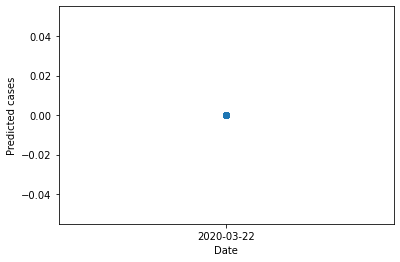

In [ ]:
plt.scatter(copied_output['date'],copied_output['cases'])
plt.xlabel("Date")
plt.ylabel("Predicted cases")
plt.show()